Pure Raman Single Spectrum PCA, tSNE, UMAP, HDBSCAN vs Siamese Embeddings

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import  numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

In [2]:
lam, p, niter = 1e4, 0.01, 10
def baseline_als(y):
    L = len(y)
    D = np.diff(np.eye(L), 2)
    D = lam * D.dot(D.T)
    w = np.ones(L)
    for _ in range(niter):
        b = np.linalg.solve(np.diag(w) + D, w * y)
        w = p * (y > b) + (1 - p) * (y < b)
    return b

def preprocess(arr):
    out = np.zeros_like(arr)
    for i, s in enumerate(arr):
        b = baseline_als(s)
        c = s - b
        norm = np.linalg.norm(c)
        out[i] = c / norm if norm > 0 else c
    return out

In [3]:
class SiameseNet(nn.Module):
    def __init__(self, input_len, embed_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=7, padding=3), nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(16, 32, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Flatten(),
            nn.Linear((input_len // 4) * 32, embed_dim),
            nn.ReLU()
        )

    def forward(self, x):
        z = self.encoder(x)
        return F.normalize(z, dim=1)

Top‑1 Acc: 100.00%, Top‑2 Acc: 100.00%


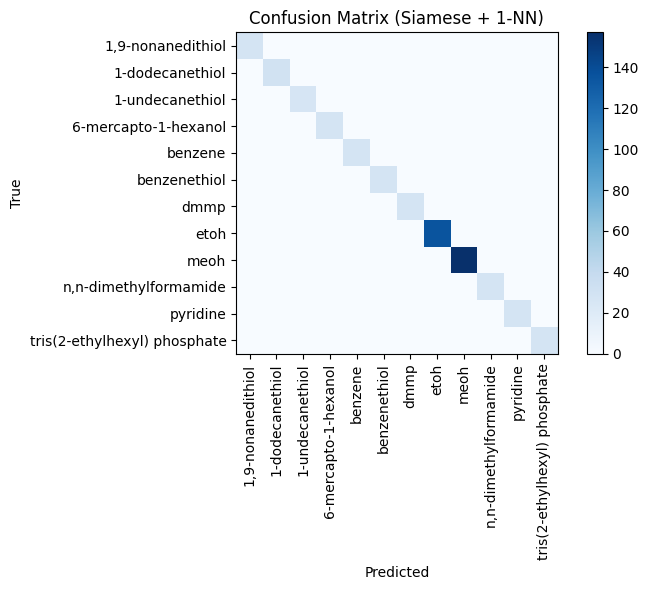

In [4]:
# 1) Load
ref_df = pd.read_csv('reference_siamese_resampled.csv')
qry_df = pd.read_csv('reference_v2.csv')

# 2) Ensure there's a 'Label' column
for df in (ref_df, qry_df):
    if 'Label' not in df.columns:
        df.rename(columns={'Species':'Label'}, inplace=True)

# 3) Convert all wavenumber‐columns to floats (so "188.000" and "188" both become 188.0)
def floatify_cols(df):
    new_cols = []
    for c in df.columns:
        # Keep any of the exact label columns unchanged
        if c in ('Label', 'Label 1', 'Label 2'):
            new_cols.append(c)
        else:
            # Convert wavenumber strings to floats
            new_cols.append(float(c))
    df.columns = new_cols


floatify_cols(ref_df)
floatify_cols(qry_df)

# 4) Now grab the common float columns
wav_cols = sorted([c for c in ref_df.columns if c!='Label'])

# 5) Extract arrays + labels
ref_specs  = ref_df[wav_cols].values
qry_specs  = qry_df[wav_cols].values
ref_labels = ref_df['Label'].values
qry_labels = qry_df['Label'].values

# 6) Preprocess
ref_proc = preprocess(ref_specs)
qry_proc = preprocess(qry_specs)

# 7) Load model
input_len = ref_proc.shape[1]
model     = SiameseNet(input_len, embed_dim=64)
model.load_state_dict(torch.load('siamese_raman_resampled.pth'))
model.eval()

# 8) Compute embeddings
with torch.no_grad():
    ref_embeds = model(torch.tensor(ref_proc, dtype=torch.float32).unsqueeze(1)).cpu().numpy()
    qry_embeds = model(torch.tensor(qry_proc, dtype=torch.float32).unsqueeze(1)).cpu().numpy()

# 9) 1‑NN / 2‑NN classification
pred1, pred2 = [], []
for q in qry_embeds:
    d = np.linalg.norm(ref_embeds - q, axis=1)
    i = np.argsort(d)
    pred1.append(ref_labels[i[0]])
    top2 = ref_labels[i[:2]] if len(i)>1 else [ref_labels[i[0]], None]
    pred2.append(tuple(top2))

# 10) Accuracy & confusion matrix
acc1 = accuracy_score(qry_labels, pred1)
acc2 = np.mean([qry_labels[i] in p for i,p in enumerate(pred2)])
print(f"Top‑1 Acc: {acc1:.2%}, Top‑2 Acc: {acc2:.2%}")

labels_u = np.unique(qry_labels)
cm = confusion_matrix(qry_labels, pred1, labels=labels_u)
plt.figure(figsize=(8,6))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.xticks(range(len(labels_u)), labels_u, rotation=90)
plt.yticks(range(len(labels_u)), labels_u)
plt.colorbar()
plt.title('Confusion Matrix (Siamese + 1‑NN)')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.tight_layout(); plt.show()


c:\Users\levinej\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\levinej\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\levinej\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\levinej\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\levinej\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_fin

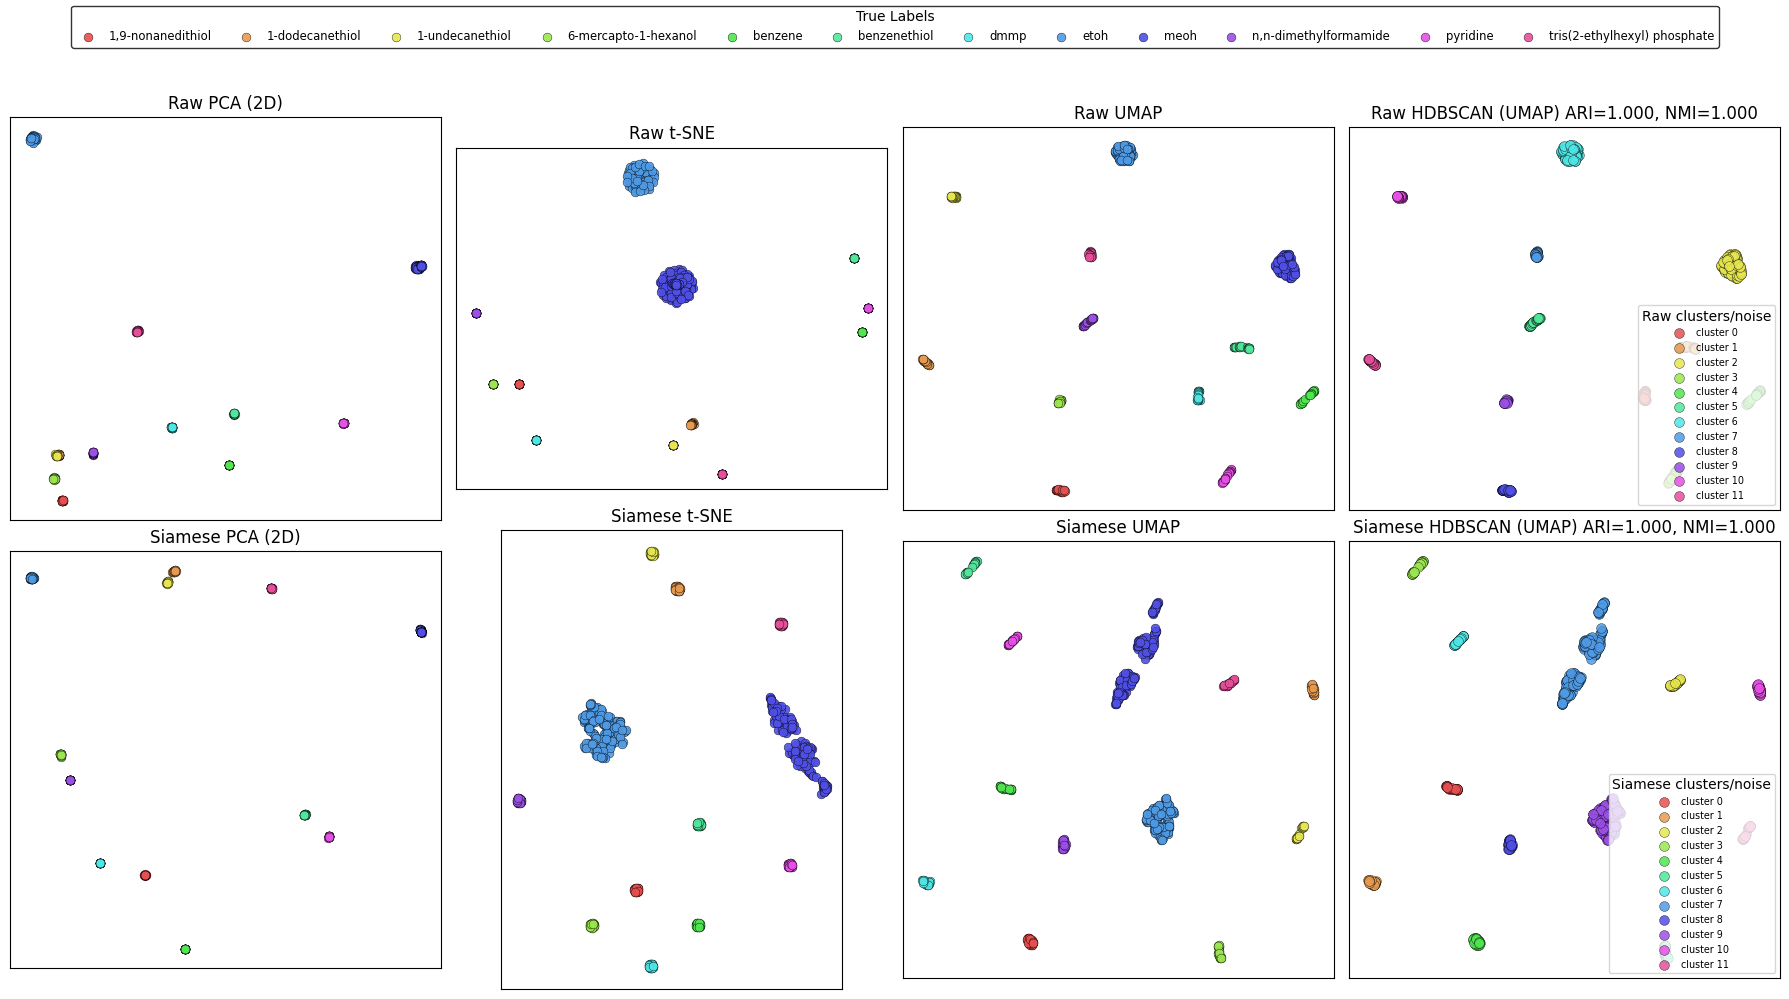

Raw HDBSCAN -> ARI: 1.0000, NMI: 1.0000
Siamese HDBSCAN -> ARI: 1.0000, NMI: 1.0000


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import hdbscan
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import colorsys

# --- helpers for distinct colors ---
def make_distinct_colors(n, saturation=0.65, value=0.9):
    """
    Returns n visually distinct RGB colors by sampling evenly in HSV space.
    """
    hues = np.linspace(0, 1, n, endpoint=False)
    colors = [colorsys.hsv_to_rgb(h, saturation, value) for h in hues]
    return colors

def scatter_2d(proj, labels, title, ax, palette=None):
    unique = np.unique(labels)
    if palette is None:
        palette = make_distinct_colors(len(unique))
    color_map = {lbl: palette[i % len(palette)] for i, lbl in enumerate(unique)}
    for lbl in unique:
        mask = labels == lbl
        ax.scatter(
            proj[mask, 0],
            proj[mask, 1],
            label=lbl,
            s=40,
            alpha=0.9,
            edgecolor='black',
            linewidth=0.3,
            color=color_map[lbl],
        )
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal', 'box')

# Assume qry_proc, qry_embeds, qry_labels in scope
# Build palettes
unique_labels = np.unique(qry_labels)
label_palette = make_distinct_colors(len(unique_labels))

# Prepare projections
pca_raw = PCA(n_components=2, random_state=0).fit_transform(qry_proc)
pca_embed = PCA(n_components=2, random_state=0).fit_transform(qry_embeds)

tsne_raw = TSNE(n_components=2, init='pca', learning_rate='auto', perplexity=30, random_state=0).fit_transform(qry_proc)
tsne_embed = TSNE(n_components=2, init='pca', learning_rate='auto', perplexity=30, random_state=0).fit_transform(qry_embeds)

umap_raw = umap.UMAP(n_components=2, random_state=0).fit_transform(qry_proc)
umap_embed = umap.UMAP(n_components=2, random_state=0).fit_transform(qry_embeds)

# HDBSCAN on original spaces
cluster_raw = hdbscan.HDBSCAN(min_cluster_size=15, prediction_data=True).fit(qry_proc)
cluster_siam = hdbscan.HDBSCAN(min_cluster_size=15, prediction_data=True).fit(qry_embeds)
clust_labels_raw = cluster_raw.labels_
clust_labels_siam = cluster_siam.labels_

# Metrics
ari_raw = adjusted_rand_score(qry_labels, clust_labels_raw)
nmi_raw = normalized_mutual_info_score(qry_labels, clust_labels_raw)
ari_siam = adjusted_rand_score(qry_labels, clust_labels_siam)
nmi_siam = normalized_mutual_info_score(qry_labels, clust_labels_siam)

# Plot grid
fig, axes = plt.subplots(2, 4, figsize=(18, 10))
# Row 0: raw
scatter_2d(pca_raw, qry_labels, "Raw PCA (2D)", axes[0, 0], palette=label_palette)
scatter_2d(tsne_raw, qry_labels, "Raw t-SNE", axes[0, 1], palette=label_palette)
scatter_2d(umap_raw, qry_labels, "Raw UMAP", axes[0, 2], palette=label_palette)

# HDBSCAN clusters in UMAP space for raw
unique_cr = np.unique(clust_labels_raw)
cluster_palette_raw = make_distinct_colors(len(unique_cr))
for i, cl in enumerate(unique_cr):
    mask = clust_labels_raw == cl
    label_name = "noise" if cl == -1 else f"cluster {cl}"
    marker = 'x' if cl == -1 else 'o'
    axes[0, 3].scatter(
        umap_raw[mask, 0],
        umap_raw[mask, 1],
        label=label_name,
        s=50,
        alpha=0.85,
        marker=marker,
        edgecolor='black',
        linewidth=0.3,
        color=cluster_palette_raw[i],
    )
axes[0, 3].set_title(f"Raw HDBSCAN (UMAP) ARI={ari_raw:.3f}, NMI={nmi_raw:.3f}")
axes[0, 3].set_xticks([])
axes[0, 3].set_yticks([])
axes[0, 3].set_aspect('equal', 'box')

# Row 1: siamese
scatter_2d(pca_embed, qry_labels, "Siamese PCA (2D)", axes[1, 0], palette=label_palette)
scatter_2d(tsne_embed, qry_labels, "Siamese t-SNE", axes[1, 1], palette=label_palette)
scatter_2d(umap_embed, qry_labels, "Siamese UMAP", axes[1, 2], palette=label_palette)

# HDBSCAN clusters in UMAP space for siamese
unique_cs = np.unique(clust_labels_siam)
cluster_palette_siam = make_distinct_colors(len(unique_cs))
for i, cl in enumerate(unique_cs):
    mask = clust_labels_siam == cl
    label_name = "noise" if cl == -1 else f"cluster {cl}"
    marker = 'x' if cl == -1 else 'o'
    axes[1, 3].scatter(
        umap_embed[mask, 0],
        umap_embed[mask, 1],
        label=label_name,
        s=50,
        alpha=0.85,
        marker=marker,
        edgecolor='black',
        linewidth=0.3,
        color=cluster_palette_siam[i],
    )
axes[1, 3].set_title(f"Siamese HDBSCAN (UMAP) ARI={ari_siam:.3f}, NMI={nmi_siam:.3f}")
axes[1, 3].set_xticks([])
axes[1, 3].set_yticks([])
axes[1, 3].set_aspect('equal', 'box')

# Shared legend for true labels (take from one of the label plots)
handles, label_names = axes[0, 0].get_legend_handles_labels()
leg = fig.legend(handles, label_names, loc='upper center', ncol=min(12, len(label_names)), frameon=True,
                 title="True Labels", fontsize='small')
leg.get_frame().set_edgecolor('black')

# Individual cluster legends
axes[0, 3].legend(loc='lower right', fontsize='x-small', title="Raw clusters/noise")
axes[1, 3].legend(loc='lower right', fontsize='x-small', title="Siamese clusters/noise")

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

# Summary print
print(f"Raw HDBSCAN -> ARI: {ari_raw:.4f}, NMI: {nmi_raw:.4f}")
print(f"Siamese HDBSCAN -> ARI: {ari_siam:.4f}, NMI: {nmi_siam:.4f}")
